In [ ]:
#from zipfile import ZipFile
#zip = ZipFile('processed-celeba-small.zip')
#zip.extractall()

In [1]:
data_dir = 'processed_celeba_small/'
import gzip
import pickle as pkl
import matplotlib.pyplot as plt  
import numpy as np
import matplotlib.cm as cm


%matplotlib inline

In [2]:
import torch,gc
from torchvision import datasets
from torchvision import transforms

In [3]:
from torch.utils.data import Dataset, DataLoader

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small'):
        
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()])
    train_dataset = datasets.ImageFolder(data_dir, transform)
    data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return data_loader

In [4]:
batch_size = 64
img_size = 32
celeba_train_loader = get_dataloader(batch_size, img_size)

<ipython-input-5-40e336e71127>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


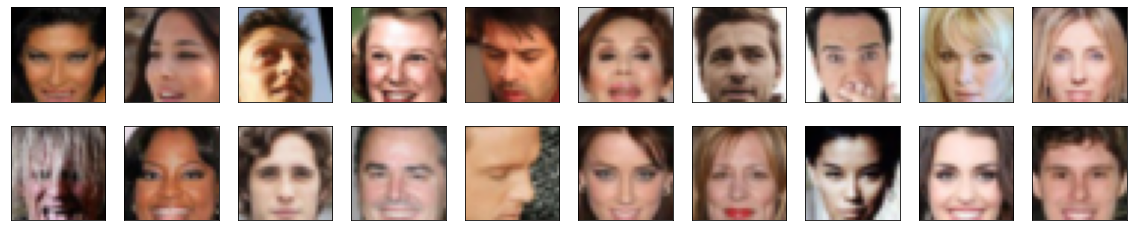

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() 
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [6]:
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [7]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.7333)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
 
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
 
        super(Discriminator, self).__init__()


        self.conv_dim = conv_dim

        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
     
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
       
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
       
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
      
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):

        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.fc(out)
        return out


In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):

        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
   
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        
    def forward(self, x):
   
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2)
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv3(out))
        out = torch.tanh(self.deconv4(out))
        return out


In [12]:
def weights_init_normal(m):

    classname = m.__class__.__name__

    if hasattr(m, 'weight') and classname.find('Conv') != -1 or classname.find('Linear') != -1: 
        m.weight.data.normal_(0.0, 0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
            m.weight.data.fill_(0.0)

In [13]:
def build_network(d_conv_dim, g_conv_dim, z_size):

    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [14]:
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

In [15]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [16]:
def real_loss(D_out):

    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*.9 
      
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)

    return loss

def fake_loss(D_out):

    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
   
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [17]:
import torch.optim as optim

lr = 0.0002
beta1=0.4 
beta2=0.999 
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [18]:
def train(D, G, n_epochs, print_every=50):
    if train_on_gpu:
        D.cuda()
        G.cuda()
    samples = []
    losses = []
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
               
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
                
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
                        
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            g_optimizer.zero_grad()
        
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) 
            
            g_loss.backward()
            g_optimizer.step()
            
            if batch_i % print_every == 0:
                
                losses.append((d_loss.item(), g_loss.item()))
                
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        G.eval() 
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() 
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [22]:
n_epochs = 20
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.3847 | g_loss: 0.7834
Epoch [    1/   20] | d_loss: 0.6962 | g_loss: 2.8466
Epoch [    1/   20] | d_loss: 1.0516 | g_loss: 1.7137
Epoch [    1/   20] | d_loss: 0.9927 | g_loss: 1.9593
Epoch [    1/   20] | d_loss: 1.0863 | g_loss: 1.4752
Epoch [    1/   20] | d_loss: 0.9436 | g_loss: 2.1332
Epoch [    1/   20] | d_loss: 1.0166 | g_loss: 2.1362
Epoch [    1/   20] | d_loss: 1.0815 | g_loss: 1.6507
Epoch [    1/   20] | d_loss: 1.1701 | g_loss: 1.3994
Epoch [    1/   20] | d_loss: 0.9861 | g_loss: 2.3823
Epoch [    1/   20] | d_loss: 0.9904 | g_loss: 2.4240
Epoch [    1/   20] | d_loss: 0.8531 | g_loss: 2.5471
Epoch [    1/   20] | d_loss: 1.1273 | g_loss: 1.8277
Epoch [    1/   20] | d_loss: 1.1492 | g_loss: 1.7631
Epoch [    1/   20] | d_loss: 1.1185 | g_loss: 0.9887
Epoch [    1/   20] | d_loss: 1.1031 | g_loss: 2.2775
Epoch [    1/   20] | d_loss: 1.0341 | g_loss: 1.7691
Epoch [    1/   20] | d_loss: 1.0538 | g_loss: 2.4223
Epoch [    1/   20] | d_loss

Epoch [    6/   20] | d_loss: 1.0651 | g_loss: 2.2700
Epoch [    6/   20] | d_loss: 1.0144 | g_loss: 1.7627
Epoch [    6/   20] | d_loss: 0.5195 | g_loss: 2.3292
Epoch [    6/   20] | d_loss: 0.6601 | g_loss: 2.5520
Epoch [    6/   20] | d_loss: 0.9336 | g_loss: 3.7077
Epoch [    6/   20] | d_loss: 0.7063 | g_loss: 2.5161
Epoch [    6/   20] | d_loss: 0.7381 | g_loss: 3.4498
Epoch [    6/   20] | d_loss: 0.6719 | g_loss: 1.8568
Epoch [    6/   20] | d_loss: 0.6431 | g_loss: 2.4608
Epoch [    6/   20] | d_loss: 0.6263 | g_loss: 1.7489
Epoch [    6/   20] | d_loss: 0.7192 | g_loss: 2.1196
Epoch [    6/   20] | d_loss: 0.7817 | g_loss: 3.3709
Epoch [    6/   20] | d_loss: 0.7018 | g_loss: 1.7553
Epoch [    6/   20] | d_loss: 0.7864 | g_loss: 1.8879
Epoch [    6/   20] | d_loss: 0.8450 | g_loss: 2.3833
Epoch [    6/   20] | d_loss: 0.5596 | g_loss: 2.6300
Epoch [    6/   20] | d_loss: 0.8899 | g_loss: 1.1349
Epoch [    6/   20] | d_loss: 0.9138 | g_loss: 2.1087
Epoch [    6/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.7433 | g_loss: 1.6748
Epoch [   11/   20] | d_loss: 0.6397 | g_loss: 2.6588
Epoch [   11/   20] | d_loss: 0.5543 | g_loss: 1.0009
Epoch [   11/   20] | d_loss: 1.2880 | g_loss: 4.0461
Epoch [   11/   20] | d_loss: 0.6597 | g_loss: 2.1477
Epoch [   11/   20] | d_loss: 0.6471 | g_loss: 2.7204
Epoch [   11/   20] | d_loss: 0.7228 | g_loss: 2.0707
Epoch [   11/   20] | d_loss: 0.9257 | g_loss: 4.4128
Epoch [   11/   20] | d_loss: 0.6614 | g_loss: 2.6450
Epoch [   11/   20] | d_loss: 0.8709 | g_loss: 3.8013
Epoch [   11/   20] | d_loss: 0.9182 | g_loss: 1.0998
Epoch [   11/   20] | d_loss: 0.7842 | g_loss: 1.4042
Epoch [   11/   20] | d_loss: 0.5615 | g_loss: 2.6910
Epoch [   11/   20] | d_loss: 0.7179 | g_loss: 1.6982
Epoch [   11/   20] | d_loss: 0.5688 | g_loss: 3.2517
Epoch [   12/   20] | d_loss: 0.7121 | g_loss: 2.9840
Epoch [   12/   20] | d_loss: 0.5447 | g_loss: 3.9604
Epoch [   12/   20] | d_loss: 0.4715 | g_loss: 3.3212
Epoch [   12/   20] | d_loss

Epoch [   16/   20] | d_loss: 0.6418 | g_loss: 3.3117
Epoch [   16/   20] | d_loss: 0.7029 | g_loss: 1.9191
Epoch [   16/   20] | d_loss: 0.5676 | g_loss: 2.3147
Epoch [   16/   20] | d_loss: 0.4327 | g_loss: 3.3556
Epoch [   16/   20] | d_loss: 0.8317 | g_loss: 1.3545
Epoch [   16/   20] | d_loss: 0.4773 | g_loss: 2.9943
Epoch [   16/   20] | d_loss: 0.6010 | g_loss: 2.4398
Epoch [   16/   20] | d_loss: 0.4966 | g_loss: 2.8747
Epoch [   17/   20] | d_loss: 0.5562 | g_loss: 4.2229
Epoch [   17/   20] | d_loss: 1.4292 | g_loss: 1.4694
Epoch [   17/   20] | d_loss: 0.6352 | g_loss: 2.4974
Epoch [   17/   20] | d_loss: 0.6400 | g_loss: 2.7429
Epoch [   17/   20] | d_loss: 0.5698 | g_loss: 2.6237
Epoch [   17/   20] | d_loss: 0.4220 | g_loss: 4.3370
Epoch [   17/   20] | d_loss: 0.4716 | g_loss: 3.1181
Epoch [   17/   20] | d_loss: 0.4867 | g_loss: 2.5048
Epoch [   17/   20] | d_loss: 0.5559 | g_loss: 2.5439
Epoch [   17/   20] | d_loss: 0.5019 | g_loss: 1.9481
Epoch [   17/   20] | d_loss

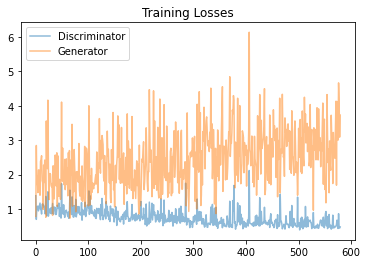

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [24]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

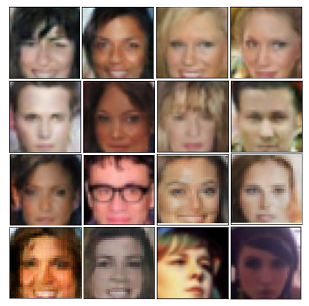

In [26]:
_ = view_samples(-1, samples)